Welcome to the supplementary information for the paper <paper title>. 

This notebook will show you how to use Compressed Sensing and Basis Pursuit Denoising to reconstruct seismic data. 

Step 1: Importing Seismic Data

Inputs: seismic data in csv format
Outputs: numpy arrays: t = time, osig = signal

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.fftpack as spfft
from scipy.interpolate import interp1d
import cvxpy as cvx
import math
import time
from obspy.io.segy.segy import _read_segy

In [2]:
#inputs

filename = f"ase_16_thumper_shot_1.csv" #file containing the seismic data 

## importing data
SE16 = pd.read_csv(filename, skiprows=8)
t = np.asarray(SE16.loc[:,['Time']])[:,0] 
osig =  np.asarray(SE16.loc[:,['G1']])[:,0]


##OPTIONAL: restricting data length to reduce computation time.
# t=t[0:2000]
# osig= osig[0:2000]

n=np.size(t) #determines the size of the reconstructed vector
L = t[-1]/1000 
ofreq = np.arange(n)/L #calculates the frequencies corresponding to each bin of the direct cosine transform for the data prior to any processing

##OPTIONAL: figure showing the data you have imported
# plt.figure(dpi=400, figsize = (10,5))
# plt.plot(t, osig, 'k', linewidth = 1)
# plt.title(f'Apollo 16 Example Waveform')
# plt.ylabel('Amplitude (Volts)')
# plt.xlabel('Time (ms)')
# plt.xlim(0,1000)
# plt.show()

Step 2: Removing existing interpolation

The JAXA repository of the Apollo 16 seismic data stores the data with an apparnet 1D nearest neighbour interpolation. This will need to be removed prior to interpolating with CS and BPD.

If you do not have an interpolation on your data, you can skip this step.

Inputs = np arrays: t = time, osig = signal
Outputs = np arrays: t2 = time without interpolation, osig2 = signal without interpolation

In [3]:
arr1 = np.array([])

for i in range(len(osig)): # this for loop will give the indexes of real data points, not those generated by the interpolation.
    if(i > 0):
        if (osig[i] != osig[i-1]):
            arr1 = np.append(arr1,i)

arr1 = arr1.astype(int)

# this will restrict the time and signal to the sampled points, removing those generated by the existing interpolation. 
osig2 = osig[arr1] 
t2 = t[arr1]

Step 3: Applying Transfer Function

The JAXA repository stores the seismic data as Volts vs time. We need to apply the transfer function to this data. 

Inputs = np.arrays: t2 = time, osig2 = signal, transfer function as data file
Outputs = np.arrays: t2 = time, newsig = signal with TF applied, freq = frequencies, new_freq = frequency domain of signal of the transformed data

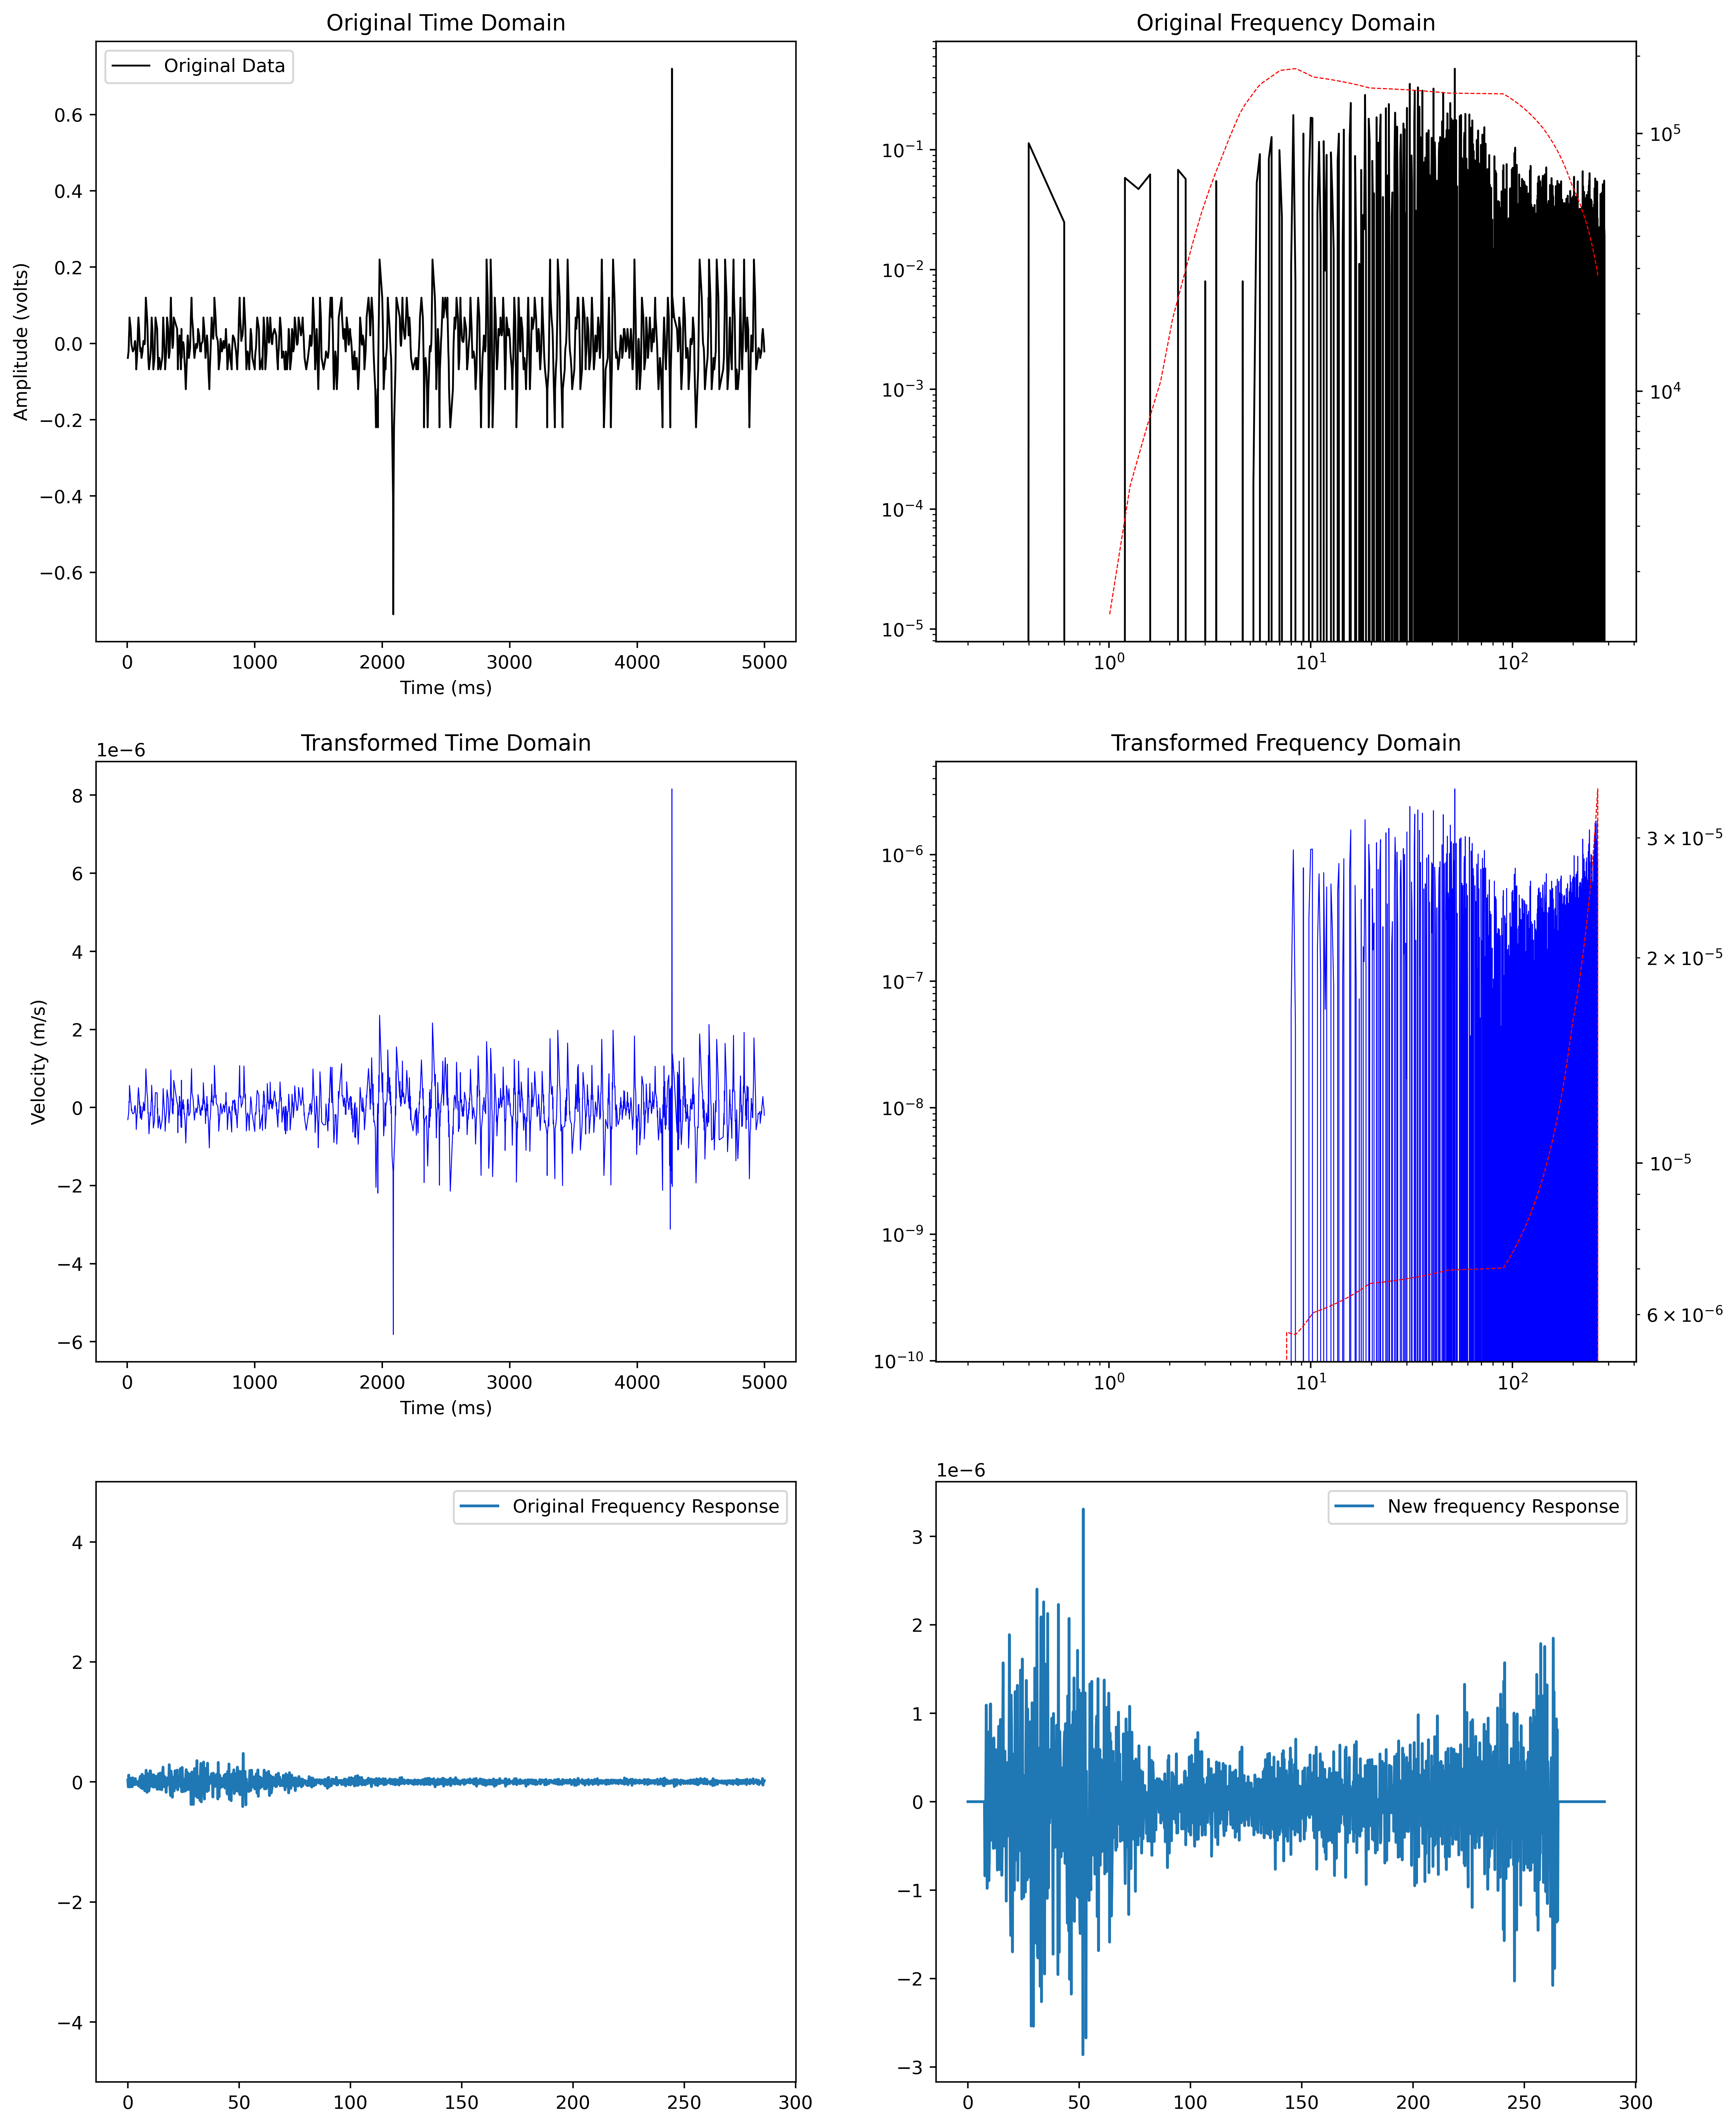

In [4]:
A16G2 = 'A16_ASE_TF.dat'
f = np.genfromtxt(A16G2,usecols=0) 
acc = np.genfromtxt(A16G2,usecols=1) 

freq = np.arange(len(osig2))/L #frequencies of the original data after the removal of existing interpolation
osig2_freq = spfft.dct(osig2, norm='ortho') # the signal in the frequency domain

plt.figure(figsize=(15,20), dpi=400)
#plot time and frequency domain data
plt.subplot(321)
plt.plot(t2, osig2, 'k', linewidth = 1,  label = 'Original Data')
plt.title(f'Original Time Domain')
plt.legend()
plt.ylabel('Amplitude (volts)')
plt.xlabel('Time (ms)')

ax1 = plt.subplot(322)
ax1.loglog(freq,osig2_freq, 'k', linewidth = 1,  label = 'Original Data' )
ax2 = ax1.twinx()
ax2.loglog(f,acc,'r--',linewidth = 0.6) #transfer function
#plt.xlim(-10,310)
plt.title(f'Original Frequency Domain')
plt.xlabel('Frequency (Hz)')

# interpolating the transfer function so it has the same size as the Apollo seismic data
ax1 = plt.subplot(324)
f2 = interp1d(f, acc, fill_value = 'extrapolate')
g6 = f2(freq)
invT = 1/g6
filt1 = ((freq < 7.5)|(freq>265)) # applying a filter to the frequency domain.
invT[filt1] = 0
# applying the transfer function
new_freq = osig2_freq*invT
ax1.loglog(freq, new_freq, 'b', linewidth = 0.5,  label = 'Transformed Data')
ax2 = ax1.twinx()
ax2.loglog(freq,invT,'r--',linewidth = 0.6)
plt.xlabel('Frequency (Hz)')
plt.title(f'Transformed Frequency Domain')

# plotting the time-domain representation of the transformed data
plt.subplot(323)
newsig = spfft.idct(new_freq, norm = 'ortho')
plt.plot(t2,newsig, 'b', linewidth = 0.5, label = 'Transformed data')
plt.ylabel('Velocity (m/s)')
plt.xlabel('Time (ms)')
plt.title(f'Transformed Time Domain')

plt.subplot(325)
plt.plot(freq,osig2_freq, label = 'Original Frequency Response')
plt.ylim(-5,5)
plt.legend()

plt.subplot(326)
plt.plot(freq,new_freq, label='New frequency Response')
plt.legend()

plt.show()

Step 4: Reconstructions 

This step is the reconstruction step. Both BP and BPD will be applied. The user can adjust the denoising level of BPD by changing epsilon. 

Inputs =  np.arrays: newsig = signal with TF applied
Outputs = np.arrays: x = BP reconstructed frequency domain data, sig = BP reconstructed time domain data, x_bpd = BPD reconstructed frequency domain data, sig_bpd = BPD reconstructed time domain data.

In [5]:
# removing mean prior to reconstruction
mean = np.mean(newsig)
newsig -= mean
m2=np.copy(newsig)

#generating transform and sampling array 'A'
# In our work, we use BP and BPD reconstructions to fill in the gaps left by removal of the existing interpolation used by JAXA.
# if you want to use this code to reconstruct other data, you will need to use arr1 to define the indexes of where the existing data will sit within the reconstruction.

A = spfft.idct(np.identity(n), norm='ortho', axis=0) #Inverse discrete cosine transform of array of size n (defined by the size of the reconstruction we are aiming for)
A = A[arr1,:] # multiplying the transform array by the sampling array (arr1) to obtain A. 


    
'''COMPRESSED SENSING '''

''' Basis Pursit'''

vx = cvx.Variable(n)
    
constraints = [A@vx == m2]
objective = cvx.Minimize(cvx.norm(vx, 1)) 
 
prob = cvx.Problem(objective, constraints) #defining the problem
result = prob.solve(verbose=True) #solving the problem
    
x = np.array(vx.value)
x = np.squeeze(x) # reconstructed frequency domain vector

sig = spfft.idct(x, norm='ortho') # back to time domain.
sig += mean # adding the mean back
    
    
    
    
    
'''Basis Pursuit Denoising'''
    
vx_bpd = cvx.Variable(n) #Full res size
    
    
epsilon = 0.00001 
constraints_bpd = [cvx.norm(A@vx_bpd - m2,2) <=epsilon]
objective_bpd=cvx.Minimize(cvx.norm(vx_bpd,1))
     
prob_bpd = cvx.Problem(objective_bpd, constraints_bpd) #defining the problem
result_bpd = prob_bpd.solve(verbose=True) #solving the problem
    
x_bpd = np.array(vx_bpd.value)
x_bpd = np.squeeze(x_bpd)
    
sig_bpd = spfft.idct(x_bpd, norm='ortho',axis=0) #back to time domain.
sig_bpd += mean

print('Reconstruction finished, proceed to next step')

                                     CVXPY                                     
                                     v1.5.2                                    
(CVXPY) Apr 17 11:49:06 AM: Your problem has 2650 variables, 1430 constraints, and 0 parameters.
(CVXPY) Apr 17 11:49:06 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 17 11:49:06 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 17 11:49:06 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Apr 17 11:49:06 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 17 11:49:06 AM: Compiling problem (target solver=CLARAB

Text(0.5, 0, 'Time (ms)')

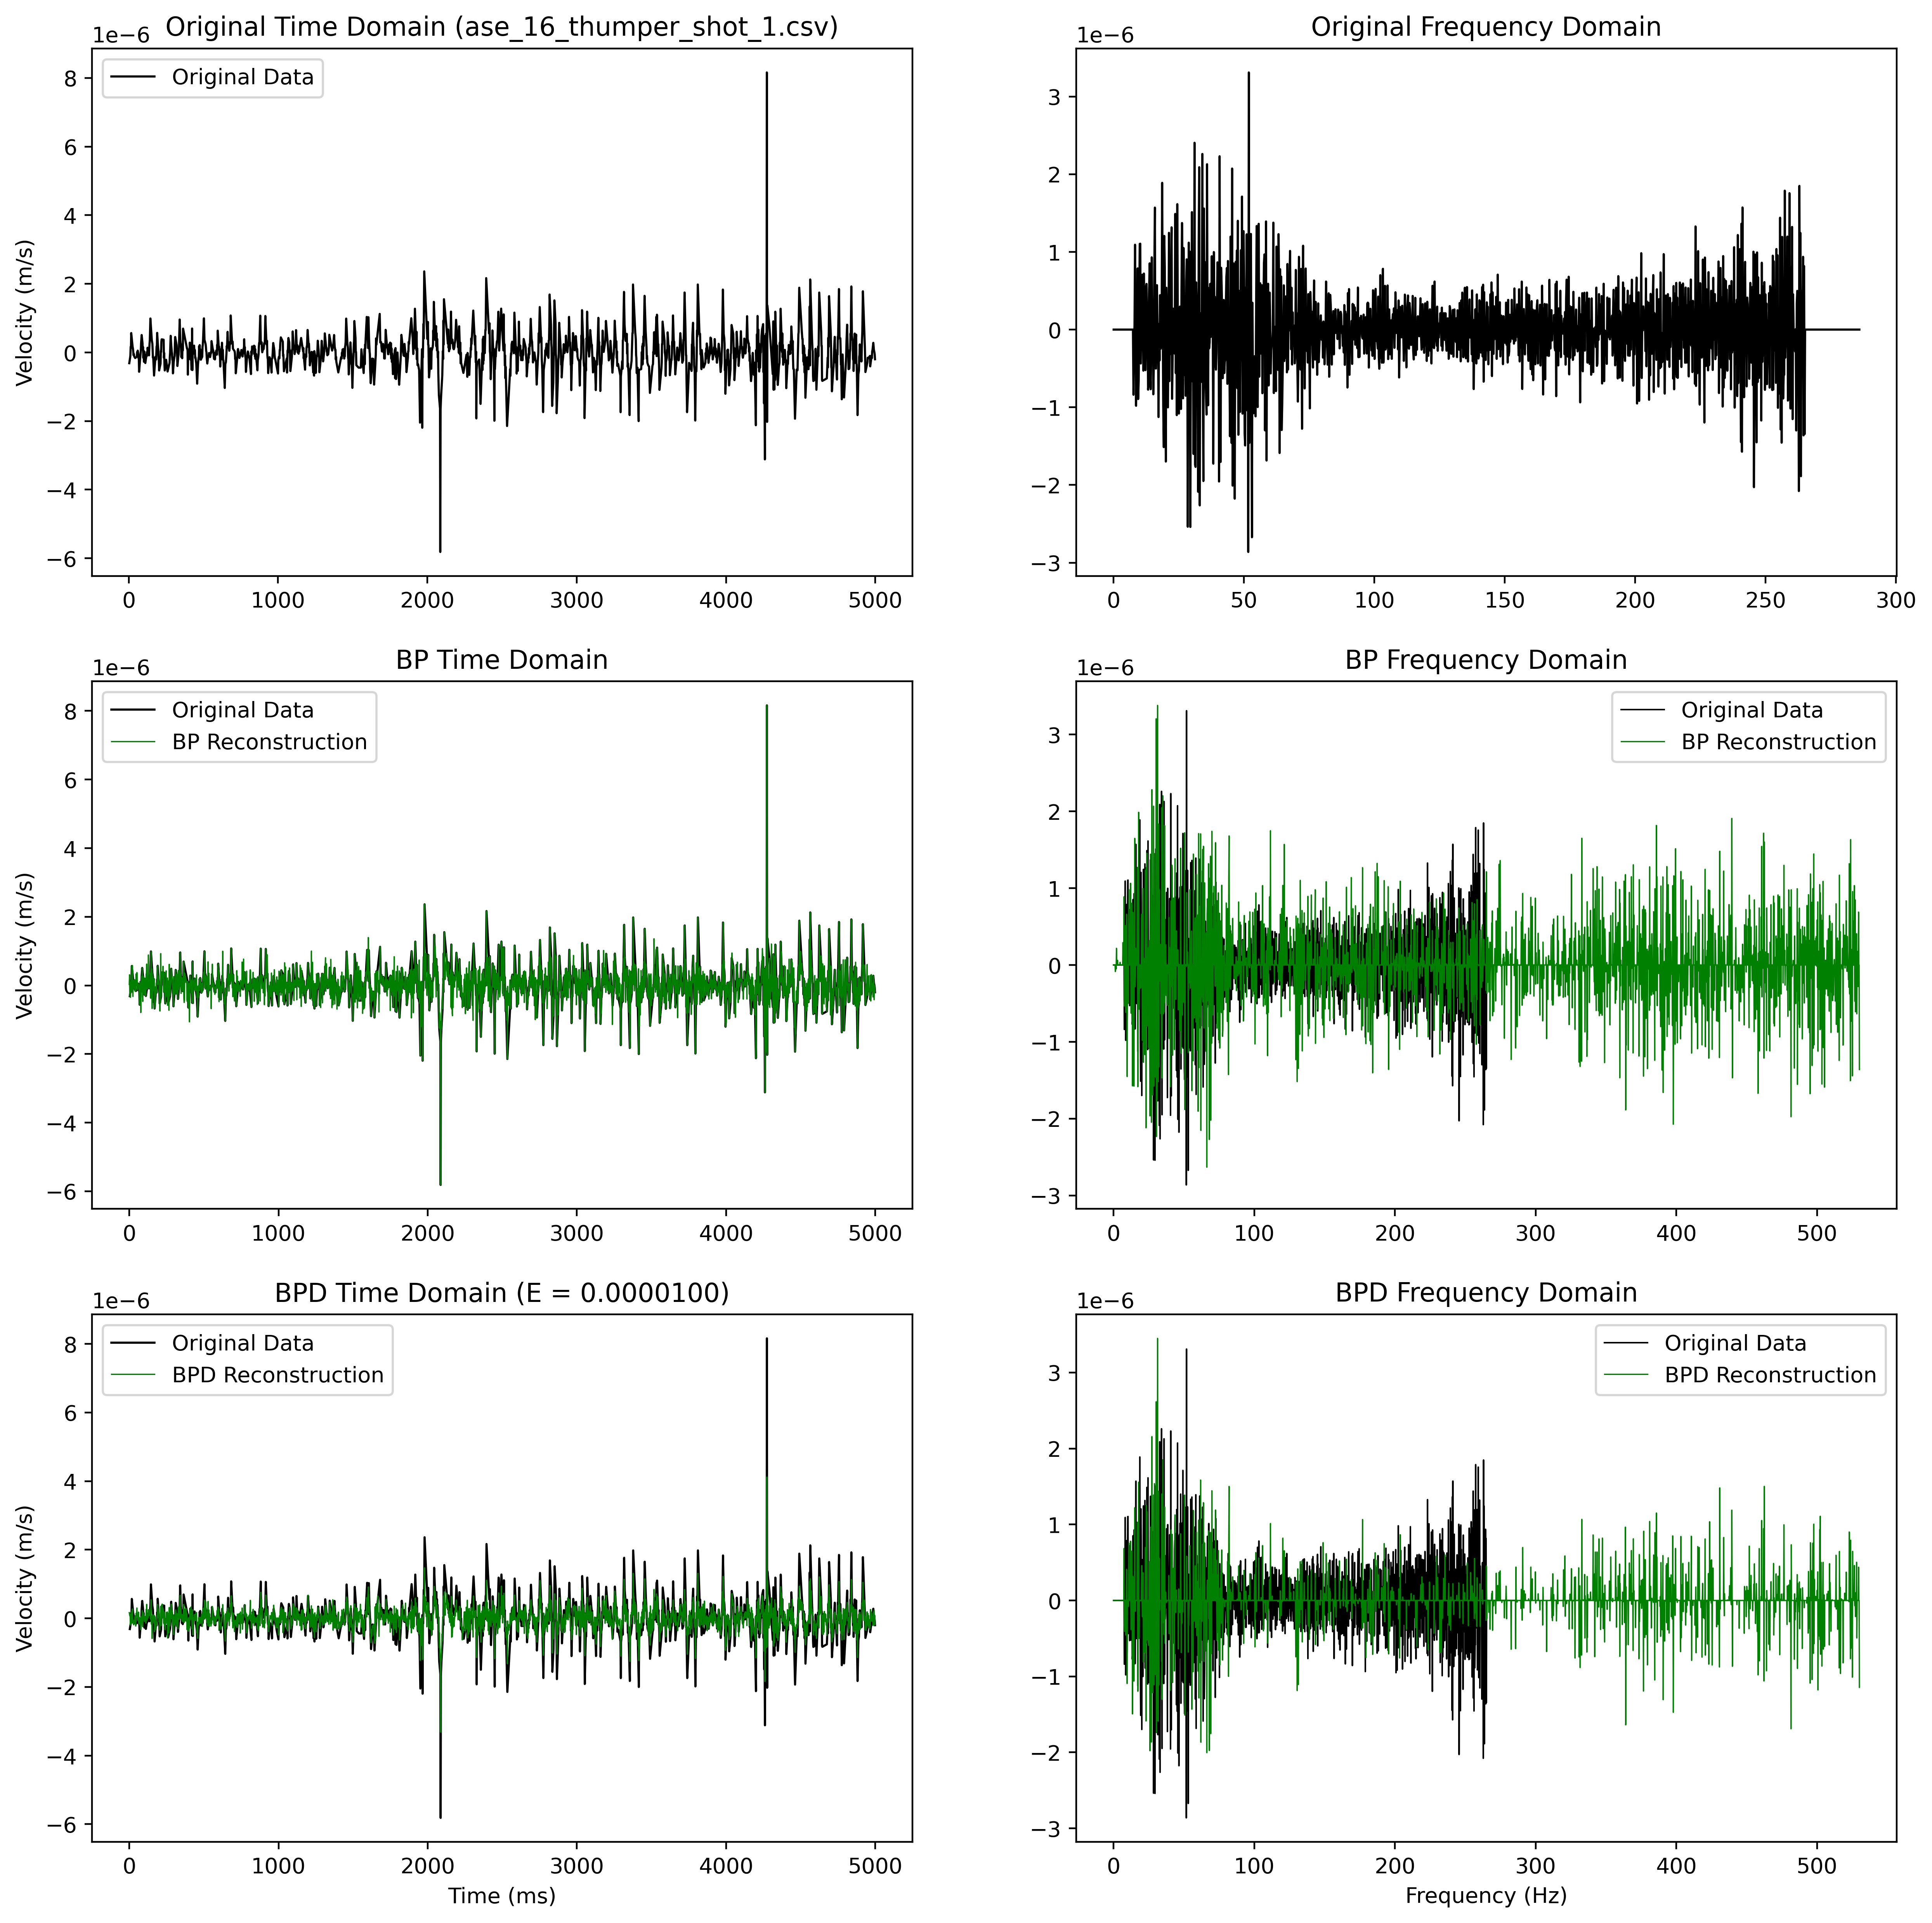

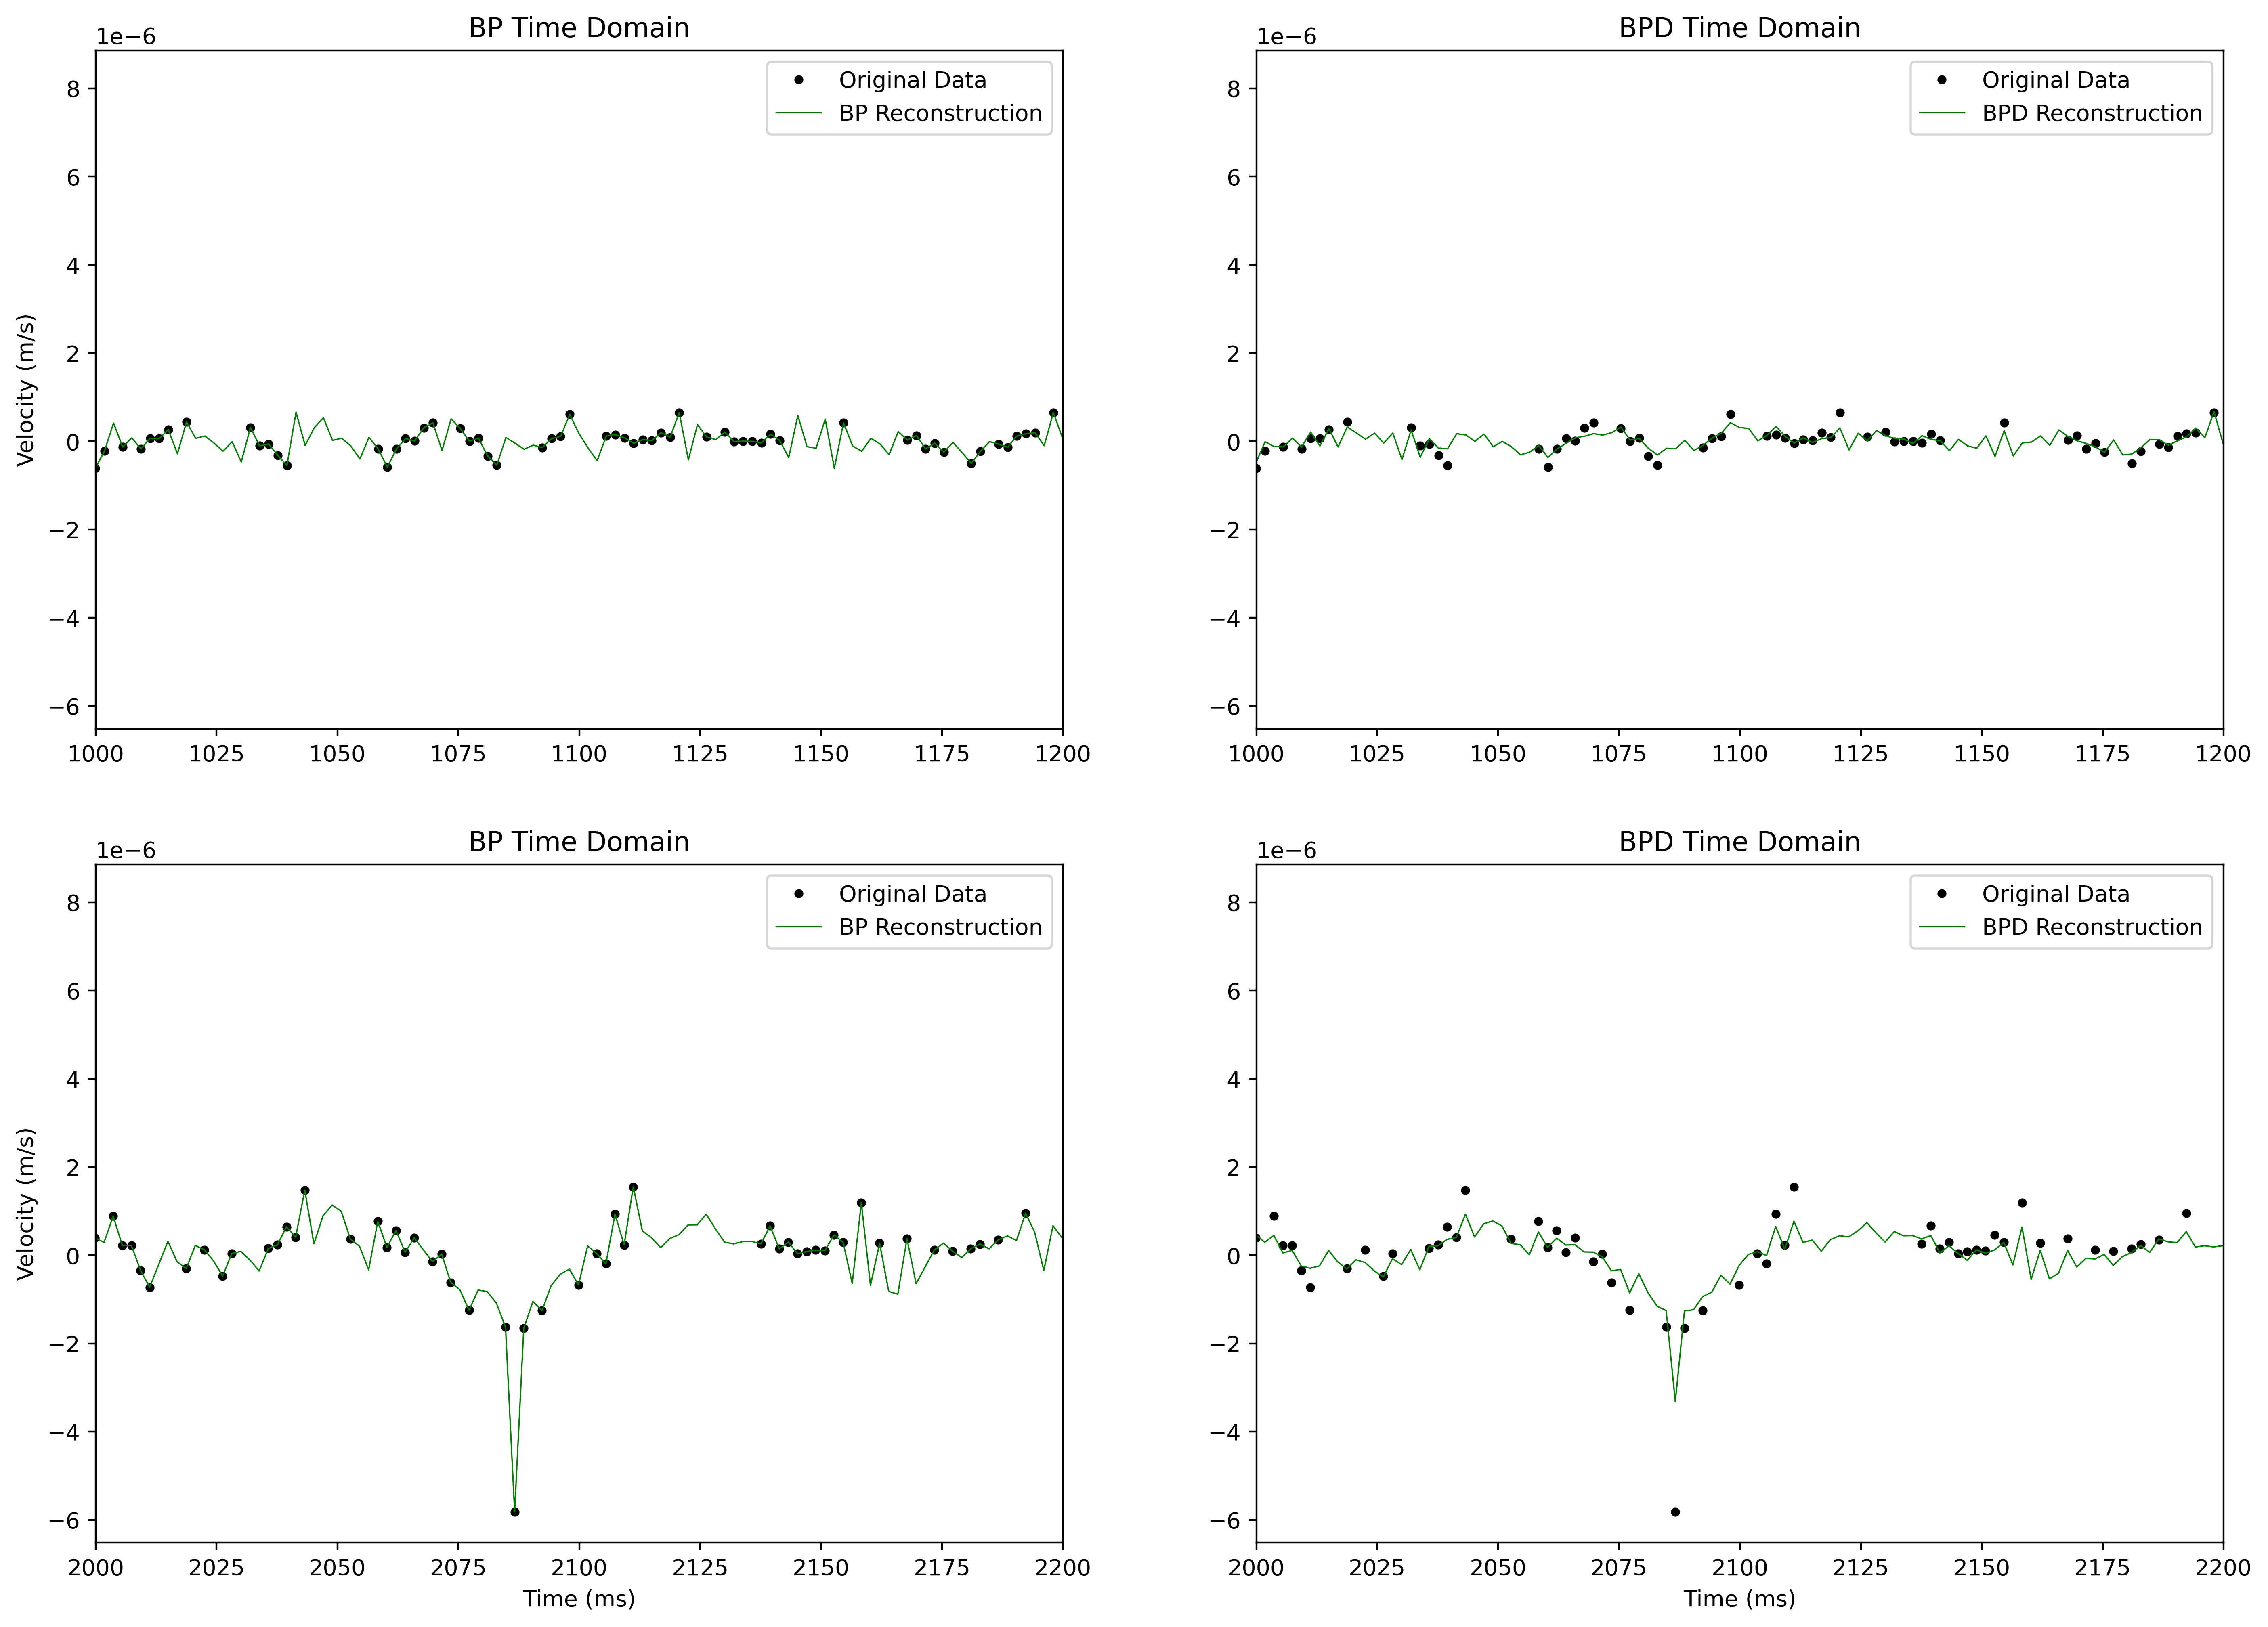

In [7]:
## plotting the reconstructions and saving the fig/data files

plt.figure(figsize=(15,15), dpi=400)
#plot time and frequency domain data original
plt.subplot(321)
plt.plot(t2, newsig, 'k', linewidth = 1,  label = 'Original Data')
plt.title(f'Original Time Domain')
plt.legend()
plt.ylabel('Velocity (m/s)')

plt.subplot(322)
plt.plot(freq,new_freq, 'k', linewidth = 1,  label = 'Original Data' )
plt.title(f'Original Frequency Domain')
    
## Plotting CS results
plt.subplot(323)
plt.plot(t2, newsig, 'k',linewidth = 1,  label = 'Original Data')
plt.plot(t, sig, 'g', linewidth = 0.6, label = 'BP Reconstruction')
plt.title(f'BP Time Domain')
plt.legend()
plt.ylabel('Velocity (m/s)')
    
plt.subplot(324)
plt.plot(freq,new_freq, 'k',linewidth = 0.7, label = 'Original Data')
plt.plot(ofreq, x, 'g', linewidth = 0.6, label = 'BP Reconstruction')
plt.legend()
plt.title(f'BP Frequency Domain')
    
    
## Plotting BPD results
plt.subplot(325)
plt.plot(t2, newsig, 'k',linewidth = 1, label = 'Original Data')
plt.plot(t, sig_bpd, 'g', linewidth = 0.6, label = 'BPD Reconstruction')
plt.title(f'BPD Time Domain (E = {epsilon:.7f})')
plt.legend()
plt.ylabel('Velocity (m/s)')
plt.xlabel('Time (ms)')
    
plt.subplot(326)
plt.plot(freq, new_freq, 'k', linewidth = 0.7, label = 'Original Data')
plt.plot(ofreq, x_bpd, 'g', linewidth = 0.6, label = 'BPD Reconstruction')
plt.legend()
plt.title(f'BPD Frequency Domain')
plt.xlabel('Frequency (Hz)')

#plt.savefig(f"Ap16_recon_{filename}.png")
    
    
###Zoom image
plt.figure(figsize=(17,12), dpi=400)
plt.subplot(221)
plt.plot(t2, newsig+mean, 'ko',linewidth = 1, markersize=3,label = 'Original Data')
plt.plot(t, sig, 'g', linewidth = 0.6, label = 'BP Reconstruction')
plt.title(f'BP Time Domain')
plt.legend()
plt.xlim(1000,1200)
plt.ylabel('Velocity (m/s)')
    
plt.subplot(222)
plt.plot(t2, newsig+mean, 'ko',linewidth = 1, markersize=3, label = 'Original Data')
plt.plot(t, sig_bpd, 'g', linewidth = 0.6, label = 'BPD Reconstruction')
plt.title(f'BPD Time Domain')
plt.legend()
plt.xlim(1000,1200)
    
plt.subplot(223)
plt.plot(t2, newsig+mean, 'ko',linewidth = 1,markersize=3, label = 'Original Data')
plt.plot(t, sig, 'g', linewidth = 0.6, label = 'BP Reconstruction')
plt.title(f'BP Time Domain')
plt.legend()
plt.xlim(2000,2200)
plt.xlabel('Time (ms)')
plt.ylabel('Velocity (m/s)')
    
plt.subplot(224)
plt.plot(t2, newsig+mean, 'ko',linewidth = 1, markersize=3, label = 'Original Data')
plt.plot(t, sig_bpd, 'g', linewidth = 0.6, label = 'BPD Reconstruction')
plt.title(f'BPD Time Domain')
plt.legend()
plt.xlim(2000,2200)
plt.xlabel('Time (ms)')


#plt.savefig(f"Ap16_recon_{filename}_zoom.png")

#np.savetxt(fr"{filename}_BP_reconstruction.dat",np.c_[t,sig])
#np.savetxt(fr"{filename}_BPD_reconstruction.dat",np.c_[t,sig_bpd])
